# Customer Segmentation of a Mall

## --- Problem definition ---

The mall holds some information about its clients, e.g. gender, age, aunnual income and spending score. These clients have subscribed to the membership card. 
When the clients subscribed to the membership card, they provided all the information. Beause they have this card they use it to buy all sorts of things in the mall
and therefore the mall has the purchase history of each of its client member. That is how they obtained the spending score.
Spending score is a score that the mall computed for each of their clients based on severlal criteria including for example thier income, 
the number of times per week they shop in the mall and of course the amount of money they spend in a year. And based on all this they computed this metric that takes
values between 1 and 100, so that the closer the spending score is to 1, the less the client spends and the closed the spending score is to 100,
the more the client spends.

The goal of this project is to find customer segments based on all these information, describe them and analyze spending score in each segment.
Solution should be delivered in a form, in which it allows easily repeat the segmentation excercise and allow quick and automated labeling of each new customer.


## --- Solution ---

In [1]:
'''This script loads and segment customer data, describe segments, label data based on the segment and saves segments centroids for future used on new data'''
   
__author__ = 'Ivana Hybenova'
__email__ = 'ivana.hybenova1@gmail.com'

### Import packages

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import pickle
import psycopg2
from sqlalchemy import create_engine
from customer_segmentation_helper import *
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Define parameters to load customers dataframe and run segmentation

In [3]:
# number of clusters for elbow method
k = 10

# path to the dataset
path_to_file = 'Mall_Customers.csv'

# Boolean value, whether dataset should be pulled from the database (PostgreSQL)
from_database = False

## Credentials to create connection to the database with psycopg2 and sqlalchemy
#database_credentials = pd.DataFrame({
#    'host': [os.environ['HOST_WAREHOUSE']],
#    'database': [os.environ['NAME_WAREHOUSE']],
#    'user': [os.environ['USER_WAREHOUSE']],
#    'password': [os.environ['PASSWORD_WAREHOUSE']],
#    'engine': [os.environ['ENGINE_WAREHOUSE']]
#})

## SQL query to download customers table
## Make sure to download the whole table as the original one will get replaced, only specified features will be used
#sql_query =  """
#               SELECT *
#               FROM customers
#             """     

# Names of categorical features
categorical_features = ['gender']

# Names of numerical features
numerical_features = ['age', 'annual_income_thousands', 'spending_score']



### Create Data object

In [4]:
data = Data(from_database=from_database, path_to_file=path_to_file, cat_cols=categorical_features, num_cols=numerical_features)

Data from the csv file/database:


,customer_id,gender,age,annual_income_thousands,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



Data with extra dummy columns:


,customer_id,gender,age,annual_income_thousands,spending_score,Female,Male
0,1,Male,19,15,39,0,1
1,2,Male,21,15,81,0,1
2,3,Female,20,16,6,1,0
3,4,Female,23,16,77,1,0
4,5,Female,31,17,40,1,0



Data with scaled features:


,customer_id,gender,age,annual_income_thousands,spending_score,Female,Male,age_scaled,annual_income_thousands_scaled,spending_score_scaled
0,1,Male,19,15,39,-1.128152,1.128152,-1.424569,-1.738999,-0.434801
1,2,Male,21,15,81,-1.128152,1.128152,-1.281035,-1.738999,1.195704
2,3,Female,20,16,6,0.886405,-0.886405,-1.352802,-1.700830,-1.715913
3,4,Female,23,16,77,0.886405,-0.886405,-1.137502,-1.700830,1.040418
4,5,Female,31,17,40,0.886405,-0.886405,-0.563369,-1.662660,-0.395980


### Find optimal number of clusters with Elbow curve

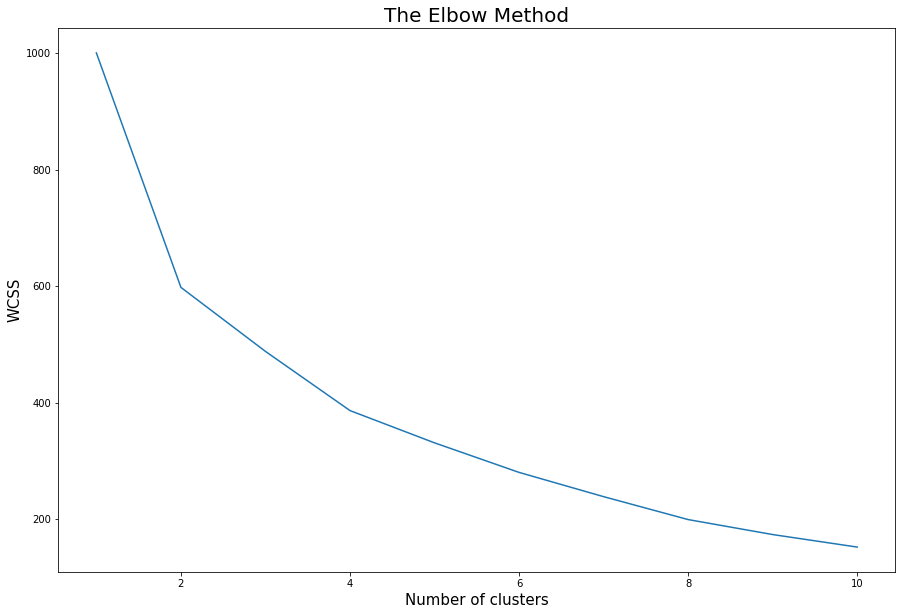

In [5]:
data.elbow_method(k = 10)

### Run customers segmentation with chosen number of clusters

In [6]:
data.get_clusters(n_clusters = 4)

Dataframe with added segment label:



,customer_id,gender,age,annual_income_thousands,spending_score,Female,Male,age_scaled,annual_income_thousands_scaled,spending_score_scaled,segment,segment_origin
0,1,Male,19,15,39,-1.128152,1.128152,-1.424569,-1.738999,-0.434801,3,created
1,2,Male,21,15,81,-1.128152,1.128152,-1.281035,-1.738999,1.195704,3,created
2,3,Female,20,16,6,0.886405,-0.886405,-1.352802,-1.700830,-1.715913,1,created
3,4,Female,23,16,77,0.886405,-0.886405,-1.137502,-1.700830,1.040418,2,created
4,5,Female,31,17,40,0.886405,-0.886405,-0.563369,-1.662660,-0.395980,2,created


### Visualize the segments in 2-dimensional feature space (after PCA transormation)

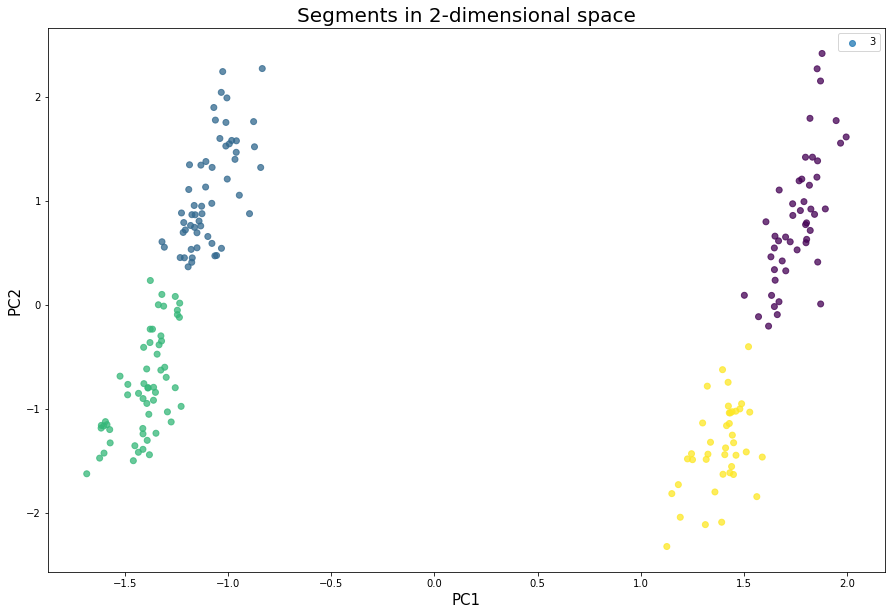

In [7]:
data.visualize_clusters()

### Describe each segment

Segment: 0    Number of Customers: 48


,gender,count,percentage
0,Male,48,100.0


,measure,age,annual_income_thousands,spending_score
0,Min value,19.0,19.0,1.0
1,25 %,40.0,46.0,12.0
2,50 %,48.0,62.0,32.0
3,Mean,49.0,62.0,29.0
4,75 %,59.0,78.0,46.0
5,Max value,19.0,19.0,1.0


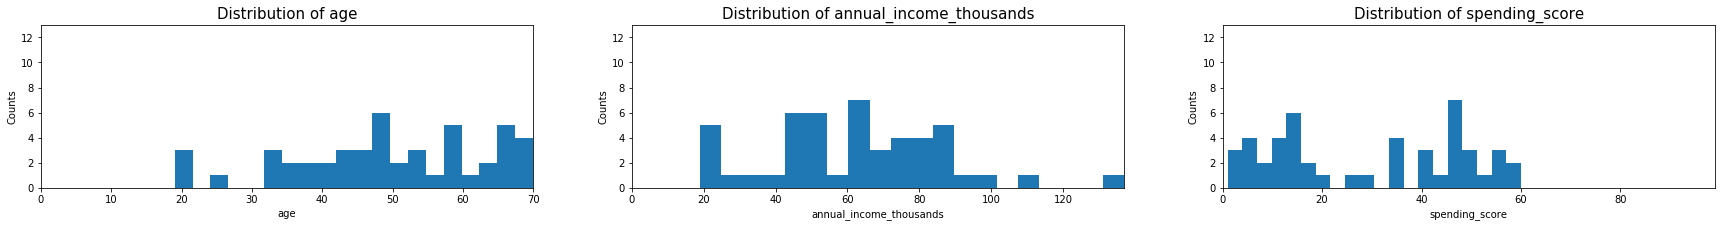

Segment: 1    Number of Customers: 55


,gender,count,percentage
0,Female,55,100.0


,measure,age,annual_income_thousands,spending_score
0,Min value,20.0,16.0,5.0
1,25 %,42.0,41.0,21.0
2,50 %,49.0,57.0,39.0
3,Mean,48.0,59.0,35.0
4,75 %,54.0,74.0,48.0
5,Max value,20.0,16.0,5.0


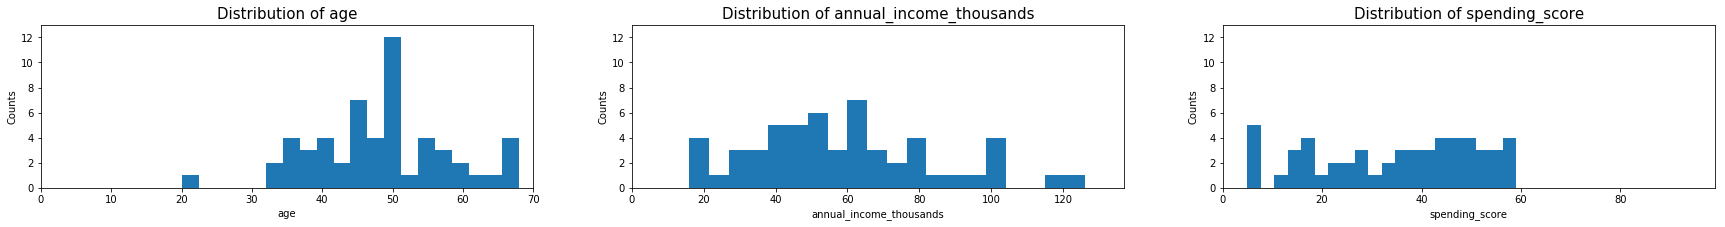

Segment: 2    Number of Customers: 57


,gender,count,percentage
0,Female,57,100.0


,measure,age,annual_income_thousands,spending_score
0,Min value,18.0,16.0,29.0
1,25 %,23.0,39.0,51.0
2,50 %,30.0,62.0,73.0
3,Mean,28.0,60.0,68.0
4,75 %,32.0,78.0,83.0
5,Max value,18.0,16.0,29.0


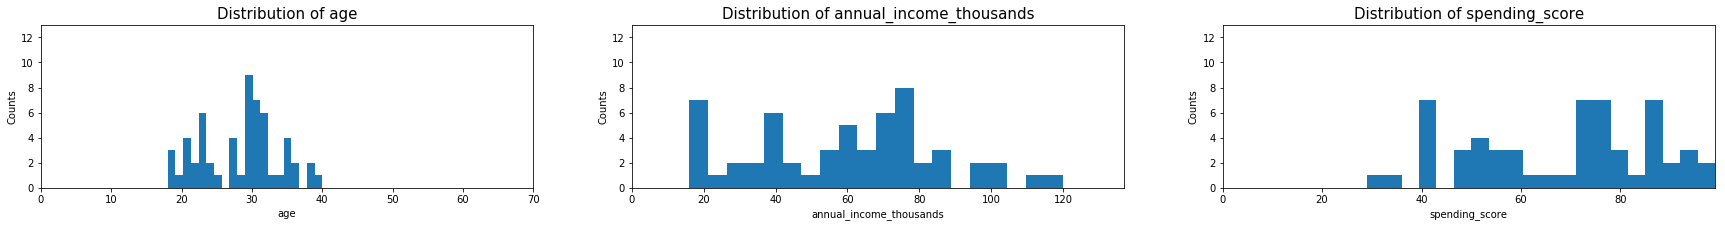

Segment: 3    Number of Customers: 40


,gender,count,percentage
0,Male,40,100.0


,measure,age,annual_income_thousands,spending_score
0,Min value,18.0,15.0,39.0
1,25 %,22.0,41.0,58.0
2,50 %,28.0,63.0,73.0
3,Mean,28.0,62.0,72.0
4,75 %,33.0,78.0,88.0
5,Max value,18.0,15.0,39.0


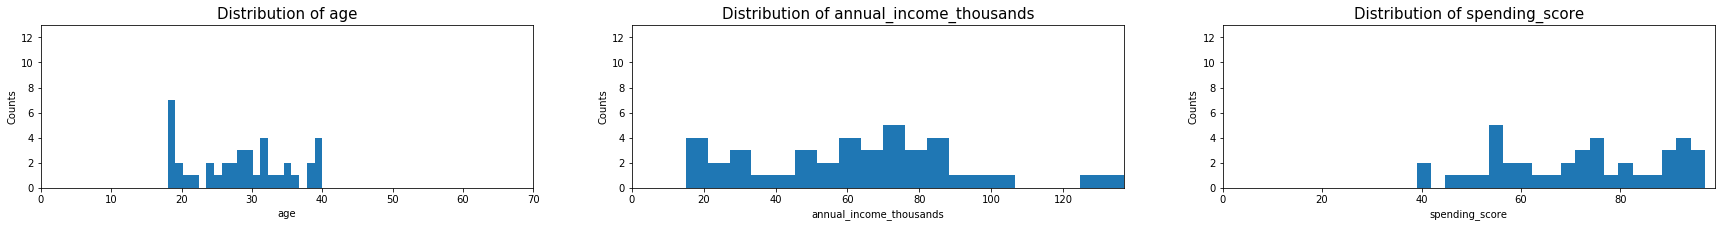

In [8]:
data.describe_clusters(ymax = 13)

#### Save the data, model and scaler mapper

In [9]:
# Rewrites existed data!
data.save_segmented_data_model()